In [1]:
import numpy as np
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import random

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model

In [3]:
ttc = pd.read_csv('train_transaction.csv', low_memory=False)
tic = pd.read_csv('train_identity.csv', low_memory=False)
tstc = pd.read_csv('test_transaction.csv', low_memory=False)
tstic = pd.read_csv('test_identity.csv', low_memory=False)


In [4]:
#code from https://github.com/kapilnchauhan77/Credit-card-fraud-detector/
def reduce_mem_usage(df):
    numv = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2 
    for col in df.columns:
        vt = df[col].dtypes
        if vt in numv:
            max_c = df[col].max()
            min_c = df[col].min()
            if str(vt)[:3] == 'int':
                if min_c > np.iinfo(np.int8).min and max_c < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif min_c > np.iinfo(np.int16).min and max_c < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif min_c > np.iinfo(np.int32).min and max_c < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif min_c > np.iinfo(np.int64).min and max_c < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if min_c > np.finfo(np.float16).min and max_c < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif min_c > np.finfo(np.float32).min and max_c < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                elif min_c > np.finfo(np.float64).min and max_c < np.finfo(np.float64).max:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

ttc = reduce_mem_usage(ttc)
tic = reduce_mem_usage(tic)
tstc = reduce_mem_usage(tstc)
tstic = reduce_mem_usage(tstic)


Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)
Mem. usage decreased to 25.44 Mb (42.7% reduction)


In [5]:
train = pd.merge(ttc, tic, on='TransactionID', how = 'left')
test = pd.merge(tstc, tstic, on='TransactionID', how = 'left')
del ttc, tic, tstc, tstic

In [6]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [7]:
miss_data = pd.isnull(train).sum().sort_values(ascending=False)
miss_per = (miss_data/len(train))*100
missing_data = pd.concat(objs= [miss_data, miss_per], keys = ['Columns', 'Missing values percentage'], axis = 1)
missing_data.head()

,Columns,Missing values percentage
id_24,585793,99.196159
id_25,585408,99.130965
id_07,585385,99.127070
id_08,585385,99.127070
id_21,585381,99.126393


In [8]:
train.head(3)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
fraud = train.loc[train['isFraud']==1]
non_fraud = train.loc[train['isFraud']==0]
print("Fraud: {}".format(len(fraud)))
print("Non Fraud: {}".format(len(non_fraud)))

Fraud: 20663
Non Fraud: 569877


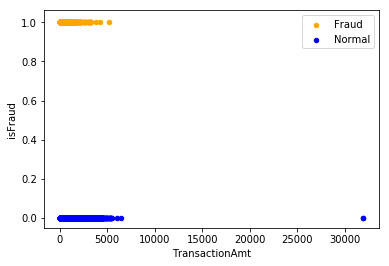

In [10]:
ax = fraud.plot.scatter(x='TransactionAmt', y='isFraud', color = 'Orange', label='Fraud')
non_fraud.plot.scatter(x='TransactionAmt', y='isFraud', color='Blue', label='Normal', ax = ax)                        

### Analysing the Data for ML

In [11]:
features = ['TransactionID'] + ['isFraud'] + ['V%d' % number for number in range(1, 339)]
target = 'isFraud'

In [12]:
train=train.fillna(0)

In [13]:
x = train[features].drop(target, axis = 1)
y = train[target]
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.35)

In [14]:
logistic = linear_model.LogisticRegression(C=1e5)
logistic.fit(X_train, y_train)
print('Score: ', logistic.score(X_test, y_test))

/media/arvid/HDD-Data/PythonPlay/py37/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Score:  0.9644877085863302


In [22]:
# checking test set for submission
features2 = ['TransactionID'] + ['V%d' % number for number in range(1,339)]
submission = test[features2].fillna(0)

y_predicted = np.array(logistic.predict(submission))  # X_test

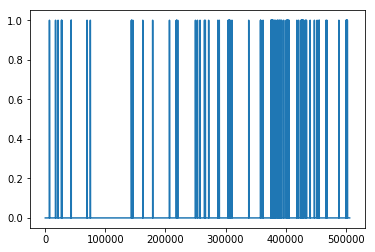

In [23]:
plt.plot(y_predicted)